In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import os
import seaborn
from matplotlib.lines import Line2D
from astropy.cosmology import Planck18
plt.rc("font", family="serif")
plt.rc("text", usetex=True)
import warnings
warnings.filterwarnings('ignore')
import astropy.coordinates as coord
import astropy.units as u
import corner
import seaborn as sns

## Read in simulated data

In [2]:
with open('../lensed_SN_catalog/Baselinev3_0_doubles.pkl', 'rb') as f:
    doubles = pickle.load(f)
with open('../lensed_SN_catalog/Baselinev3_0_quads.pkl', 'rb') as f:
    quads = pickle.load(f)
with open('../lensed_SN_catalog/Baselinev3_0_unlensed.pkl', 'rb') as f:
    sne = pickle.load(f)
    
print("Doubles: ", len(doubles))
print("Quads: ", len(quads))
print("Unlensed: ", len(sne))

Doubles:  5000
Quads:  5000
Unlensed:  5000


In [3]:
doubles.keys()

Index(['time_series', 'z_source', 'z_lens', 'H0', 'theta_E', 'obs_peak',
       'obs_times', 'obs_bands', 'model_mag', 'obs_mag', 'obs_mag_error',
       'obs_snr', 'obs_mag_unresolved', 'mag_unresolved_error',
       'snr_unresolved', 'macro_mag', 'source_x', 'source_y', 'time_delay',
       'time_delay_distance', 'image_x', 'image_y', 'gamma_lens', 'e1_lens',
       'e2_lens', 'g1_shear', 'g2_shear', 'micro_kappa', 'micro_gamma',
       'micro_s', 'micro_peak', 'stretch', 'colour', 'Mb', 'obs_start',
       'obs_end', 'mult_method_peak', 'mult_method', 'mult_method_micro',
       'mag_method_peak', 'mag_method', 'mag_method_micro', 'coords',
       'obs_skybrightness', 'obs_psf', 'obs_lim_mag', 'obs_N_coadds', 'survey',
       'rolling', 'obs_mag_micro', 'mag_micro_error', 'obs_snr_micro',
       'mag_unresolved_micro', 'mag_unresolved_micro_error',
       'snr_unresolved_micro', 'peak_magnitudes', 'peak_magnitudes_micro'],
      dtype='object')

## Read in summary statistics

In [28]:
print("Columns: SNID  Npremax Nfilt obs_start   theta_E     mB      dt_input")

sumstat_doubles = np.genfromtxt('../lensed_SN_catalog/sumstat_earlydet_doubles.txt',
                  dtype=['U15', np.float, np.float, np.float, np.float, np.float, np.float])[1:]
sumstat_quads = np.genfromtxt('../lensed_SN_catalog/sumstat_earlydet_quads.txt',
                  dtype=['U15', np.float, np.float, np.float, np.float, np.float, np.float])[1:]

sumstat_d, sumstat_q = [], []

for s in range(len(sumstat_quads)):
    
    if s < len(sumstat_doubles):
        d = sumstat_doubles[s]
        d_row = np.array([float(d[0][2:]), d[1], d[2], d[3], d[4], d[5], d[6]])
        sumstat_d.append(d_row)
    
    q = sumstat_quads[s]
    q_row = np.array([float(q[0][2:]), q[1], q[2], q[3], q[4], q[5], q[6]])
    sumstat_q.append(q_row)
    
sumstat_d = np.array(sumstat_d)
sumstat_q = np.array(sumstat_q)

print("Doubles: ", np.shape(sumstat_d))
print("Quads: ", np.shape(sumstat_q))

Columns: SNID  Npremax Nfilt obs_start   theta_E     mB      dt_input
Doubles:  (1896, 7)
Quads:  (2953, 7)


In [17]:
sumstat_d_detect = []
sumstat_q_detect = []

for i in range(len(sumstat_d)):
    # If in detected sample
    if md_detected_micro[int(sumstat_d[i][0])]:
        sumstat_d_detect.append(sumstat_d[i])
        
for j in range(len(sumstat_q)):
    # If in detected sample
    if mq_detected_micro[int(sumstat_q[j][0])]:
        sumstat_q_detect.append(sumstat_q[j])

sumstat_d_detect = np.array(sumstat_d_detect)
sumstat_q_detect = np.array(sumstat_q_detect)

print("Doubles: ", np.shape(sumstat_d_detect))
print("Quads: ", np.shape(sumstat_q_detect))

Doubles:  (1237, 7)
Quads:  (2723, 7)


In [18]:
# New list for N_early: if no information assume zero 
# Also save list with True False if in gold sample

Nearly_d, Nearly_q = [], []
sumstat_indices_d = np.array([int(x) for x in sumstat_d_detect[:,0]])
sumstat_indices_q = np.array([int(x) for x in sumstat_q_detect[:,0]])
gold_d, gold_q = [], []

for i in range(len(doubles)):
    # --------------------------------------------------
    # Doubles
    goldsample_doubles = False
    # In detected sample
    if md_detected_micro[i]:
        # In sumstat list
        if i in sumstat_indices_d:
            index = np.where(sumstat_indices_d == i)[0][0]
            Nearly_d.append(sumstat_d_detect[index, 1])
            
            # For gold sample: 
            if sumstat_d_detect[index, 1] > 5:
                if sumstat_d_detect[index, 2] > 1:
                    if peak_i_doubles[i] < 22.5:
                        if dt_doubles[i] > 10:
                            # Passed!
                            goldsample_doubles = True
        else:
            Nearly_d.append(0.0)
            
    if goldsample_doubles:
        gold_d.append(True)
    else:
        gold_d.append(False)
    
    # --------------------------------------------------
    # Quads
    goldsample_quads = False
    # In detected sample
    if mq_detected_micro[i]:
        # In sumstat list
        if i in sumstat_indices_q:
            index = np.where(sumstat_indices_q == i)[0][0]
            Nearly_q.append(sumstat_q_detect[index, 1])
            
            # For gold sample: 
            if sumstat_q_detect[index, 1] > 5:
                if sumstat_q_detect[index, 2] > 1:
                    if peak_i_quads[i] < 22.5:
                        if dt_quads[i] > 10:
                            # Passed!
                            goldsample_quads = True
        else:
            Nearly_q.append(0.0)
            
    if goldsample_quads:
        gold_q.append(True)
    else:
        gold_q.append(False) 
    # --------------------------------------------------
            
Nearly_d = np.array(Nearly_d)
Nearly_q = np.array(Nearly_q)
gold_d = np.array(gold_d)
gold_q = np.array(gold_q)

print("Doubles: ", np.shape(Nearly_d), len(gold_d), gold_d.sum())
print("Quads: ", np.shape(Nearly_q), len(gold_q), gold_q.sum())

Doubles:  (2057,) 5000 454
Quads:  (3462,) 5000 780


## Compute detected sample

In [4]:
dt_doubles, dt_quads = [], []
mutot_doubles, mutot_quads = [], []
peak_i_doubles, peak_i_quads = [], []
peak_r_doubles, peak_r_quads = [], []
peak_z_doubles, peak_z_quads = [], []
peak_y_doubles, peak_y_quads = [], []

for s in range(len(doubles)):
    
    dt_doubles.append(doubles['time_delay'][s][1])
    dt_quads.append(max(quads['time_delay'][s]))
    mutot_doubles.append(np.sum(doubles['macro_mag'][s]))
    mutot_quads.append(np.sum(quads['macro_mag'][s]))
    peak_r_doubles.append(doubles['peak_magnitudes_micro'][s][1])
    peak_r_quads.append(quads['peak_magnitudes_micro'][s][1])
    peak_i_doubles.append(doubles['peak_magnitudes_micro'][s][2])
    peak_i_quads.append(quads['peak_magnitudes_micro'][s][2])
    peak_z_doubles.append(doubles['peak_magnitudes_micro'][s][3])
    peak_z_quads.append(quads['peak_magnitudes_micro'][s][3])
    peak_y_doubles.append(doubles['peak_magnitudes_micro'][s][4])
    peak_y_quads.append(quads['peak_magnitudes_micro'][s][4])
    
dt_doubles = np.array(dt_doubles)
dt_quads = np.array(dt_quads)
mutot_doubles = np.array(mutot_doubles)
mutot_quads = np.array(mutot_quads)
peak_r_doubles = np.array(peak_r_doubles)
peak_r_quads = np.array(peak_r_quads)
peak_i_doubles = np.array(peak_i_doubles)
peak_i_quads = np.array(peak_i_quads)
peak_z_doubles = np.array(peak_z_doubles)
peak_z_quads = np.array(peak_z_quads)
peak_y_doubles = np.array(peak_y_doubles)
peak_y_quads = np.array(peak_y_quads)

In [6]:
# masks

# Rolling / non-rolling
md_nonrol = (doubles['obs_start']) <= 60768
md_rol = (doubles['obs_start']) > 60768
mq_nonrol = (quads['obs_start']) <= 60768
mq_rol = (quads['obs_start']) > 60768

# Survey
md_WFD = (doubles['survey']) == 'WFD'
md_DDF = (doubles['survey']) == 'DDF'
md_gal = (doubles['survey']) == 'galactic plane'
mq_WFD = (quads['survey']) == 'WFD'
mq_DDF = (quads['survey']) == 'DDF'
mq_gal = (quads['survey']) == 'galactic plane'

# Detected
md_detected = (doubles['mag_method'] == True) | (doubles['mult_method'] == True)
md_detected_micro = (doubles['mag_method_micro'] == True) | (doubles['mult_method_micro'] == True)
md_detected_peak = (doubles['mag_method_peak'] == True) | (doubles['mult_method_peak'] == True)
md_nondetect_micro = (doubles['mag_method_micro'] == False) & (doubles['mult_method_micro'] == False)
md_nondetect = (doubles['mag_method'] == False) & (doubles['mult_method'] == False)
mq_detected_micro = (quads['mag_method_micro'] == True) | (quads['mult_method_micro'] == True)
mq_detected = (quads['mag_method'] == True) | (quads['mult_method'] == True)
mq_nondetect_micro = (quads['mag_method_micro'] == False) & (quads['mult_method_micro'] == False)
mq_nondetect = (quads['mag_method'] == False) & (quads['mult_method'] == False)
mq_detected_peak = (quads['mag_method_peak'] == True) | (quads['mult_method_peak'] == True)

md_detected_micro_mag = (doubles['mag_method_micro'] == True)
md_detected_micro_mult = (doubles['mult_method_micro'] == True)
mq_detected_micro_mag = (quads['mag_method_micro'] == True)
mq_detected_micro_mult = (quads['mult_method_micro'] == True)

md_mult_peak = (doubles['mult_method_peak'] == True)
md_mag_peak = (doubles['mag_method_peak'] == True)
mq_mult_peak = (quads['mult_method_peak'] == True)
mq_mag_peak = (quads['mag_method_peak'] == True)

# Minimum time delay
dt_lim = 10
md_dt_lim = dt_doubles > dt_lim
mq_dt_lim = dt_quads > dt_lim

md_thetaE = doubles['theta_E'] > 0.5
mq_thetaE = quads['theta_E'] > 0.5

print("Doubles detected: ", md_detected_micro.sum())
print("Quads detected: ", mq_detected_micro.sum())

Doubles detected:  2057
Quads detected:  3462


Text(0.5, 0.98, 'Differences between doubles and quads (detected sample)')

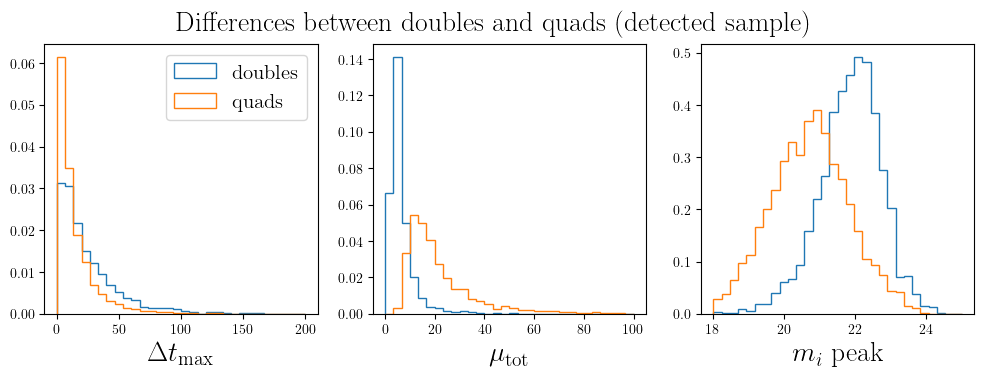

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3.5))

properties_d = [dt_doubles[md_detected_micro], mutot_doubles[md_detected_micro], peak_i_doubles[md_detected_micro]]
properties_q = [dt_quads[mq_detected_micro], mutot_quads[mq_detected_micro], peak_i_quads[mq_detected_micro]]
ranges = [(0, 200), (0, 100), (18, 25)]
labels = [r'$\Delta t_{\rm max}$', r'$\mu_{\rm tot}$', r'$m_i$ peak']
bins=30

for i in range(3):
    ax[i].hist(properties_d[i], range=ranges[i], histtype='step', bins=bins, density=True, label='doubles')
    ax[i].hist(properties_q[i], range=ranges[i], histtype='step', bins=bins, density=True, label='quads')
    ax[i].set_xlabel(labels[i], fontsize=20)
ax[0].legend(fontsize=15)
fig.suptitle("Differences between doubles and quads (detected sample)", fontsize=20)
#plt.savefig("../Results/Figures/Results_0506/Goldsample.png", transparent=False, facecolor='white', dpi=250, bbox_inches='tight')


### Figure 2

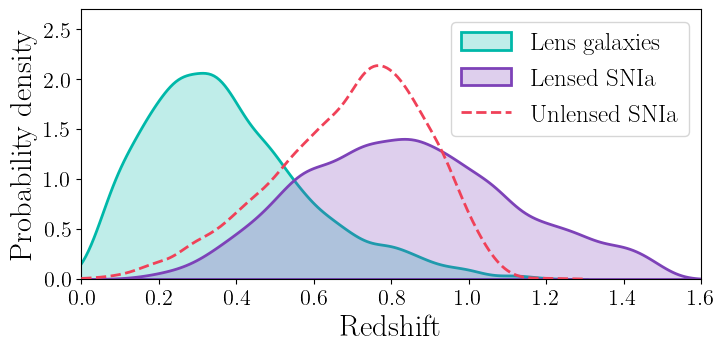

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3.5))
zrange = (0, 1.5)

z_lens_list = list(doubles['z_lens'][md_detected]) + list(quads['z_lens'][mq_detected])
z_source_list = list(doubles['z_source'][md_detected]) + list(quads['z_source'][mq_detected])

# 00b8a9 00bfc9 
# blå: 49c0c4

sns.kdeplot(z_lens_list, ax=ax, lw=2, color="#00b8a9", fill=True, label="Lens galaxies", zorder=1)
sns.kdeplot(z_source_list, ax=ax, lw=2, color="#7d42b8", fill=True, label="Lensed SNIa", zorder=2)
sns.kdeplot(sne['z_source'], ax=ax, lw=2, color="#f04158", fill=False, label="Unlensed SNIa", ls='--', zorder=100)

handles,labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[2], handles[0]]
labels = [labels[1], labels[2], labels[0]]

ax.legend(handles,labels, fontsize=18)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
# ax.set_yticks([])
plt.xlim(0, 1.6)
plt.ylim(0, 2.7)
plt.xlabel(r"Redshift", fontsize=22)
plt.ylabel(r"Probability density", fontsize=22, labelpad=5)
#plt.savefig("../Results/Figures/z_distributions.png", transparent=False, facecolor='white', dpi=250, bbox_inches='tight')
plt.show()

In [24]:
print("Yearly predicted lensed SNIa detections (WFD)")
print(" ")

# Scale by yearly predicted rates by Wojtak et al.
rates_total = 89 * 3
fraction_quads = 0.28
fraction_doubles = 0.72
rates_quads = rates_total * fraction_quads
rates_doubles = rates_total * fraction_doubles

sd2 = rates_doubles / ((md_WFD) & (md_detected_peak)).sum() / 1.5 /20000 * 18000
sq2 = rates_quads / ((mq_WFD) & (mq_detected_peak)).sum() / 1.5 /20000 * 18000

print("--- Doubles ---")
print("             Non-rolling    ---    Rolling")
print("N detected peak:  ",  ((md_WFD) & (md_detected_peak) & (md_nonrol)).sum()*sd2,"    ", 
                            ((md_WFD) & (md_detected_peak) & (md_rol)).sum()*sd2)
print("N detected  :     ",  ((md_WFD) & (md_detected) & (md_nonrol)).sum()*sd2,"    ", 
                            ((md_WFD) & (md_detected) & (md_rol)).sum()*sd2)
print("N detected micro: ",  ((md_WFD) & (md_detected_micro) & (md_nonrol)).sum()*sd2,"    ", 
                            ((md_WFD) & (md_detected_micro) & (md_rol)).sum()*sd2)
print("dt > 10 :         ",  ((md_dt_lim) & (md_WFD) & (md_detected_micro) & (md_nonrol)).sum()*sd2,"    ", 
                            ((md_dt_lim) & (md_WFD) & (md_detected_micro) & (md_rol)).sum()*sd2)
print("Gold sample :     ",  ((gold_d) & (md_WFD) & (md_detected_micro) & (md_nonrol)).sum()*sd2,"    ", 
                            ((gold_d) & (md_WFD) & (md_detected_micro) & (md_rol)).sum()*sd2)
print("only mag method : ",  ((md_WFD) & (md_detected_micro_mag) & (md_nonrol)).sum()*sd2,"    ", 
                            ((md_WFD) & (md_detected_micro_mag) & (md_rol)).sum()*sd2)
print(" ")

print("--- Quads ---")
print("             Non-rolling    ---    Rolling")
print("N detected peak:  ",  ((mq_WFD) & (mq_detected_peak) & (mq_nonrol)).sum()*sq2,"    ", 
                            ((mq_WFD) & (mq_detected_peak) & (mq_rol)).sum()*sq2)
print("N detected  :     ",  ((mq_WFD) & (mq_detected) & (mq_nonrol)).sum()*sq2,"    ", 
                            ((mq_WFD) & (mq_detected) & (mq_rol)).sum()*sq2)
print("N detected micro: ",  ((mq_WFD) & (mq_detected_micro) & (mq_nonrol)).sum()*sq2,"    ", 
                            ((mq_WFD) & (mq_detected_micro) & (mq_rol)).sum()*sq2)
print("dt > 10           ",  ((mq_dt_lim) & (mq_WFD) & (mq_detected_micro) & (mq_nonrol)).sum()*sq2,"    ", 
                            ((mq_dt_lim) & (mq_WFD) & (mq_detected_micro) & (mq_rol)).sum()*sq2)
print("Gold sample :     ",  ((gold_q) & (mq_WFD) & (mq_detected_micro) & (mq_nonrol)).sum()*sq2,"    ", 
                            ((gold_q) & (mq_WFD) & (mq_detected_micro) & (mq_rol)).sum()*sq2)
print("only mag method:  ",  ((mq_WFD) & (mq_detected_micro_mag) & (mq_nonrol)).sum()*sq2,"    ", 
                            ((mq_WFD) & (mq_detected_micro_mag) & (mq_rol)).sum()*sq2)
print(" ")

print("--- Total ---")
print("             Non-rolling    ---    Rolling")
print("without microlensing:")
print("N detected  :     ",  ((mq_WFD) & (mq_detected) & (mq_nonrol)).sum()*sq2 + ((md_WFD) & (md_detected) & (md_nonrol)).sum()*sd2,"    ", 
                            ((mq_WFD) & (mq_detected) & (mq_rol)).sum()*sq2 + ((md_WFD) & (md_detected) & (md_rol)).sum()*sd2)
print("N with time delay > 10 days : ", ((mq_WFD) & (mq_detected) & (mq_nonrol) & (mq_dt_lim)).sum()*sq2 + ((md_WFD) & (md_detected) & (md_nonrol) & (md_dt_lim)).sum()*sd2,"    ", 
                            ((mq_WFD) & (mq_detected) & (mq_rol) & (mq_dt_lim)).sum()*sq2 + ((md_WFD) & (md_detected) & (md_rol) & (md_dt_lim)).sum()*sd2)
print("Total N of lensed SNe: ", (((md_WFD) & (md_detected)).sum()*sd2 + ((mq_WFD) & (mq_detected)).sum()*sq2)/2)
print(" ")

print("with microlensing:")
print("N detected  :     ",  ((mq_WFD) & (mq_detected_micro) & (mq_nonrol)).sum()*sq2 + ((md_WFD) & (md_detected_micro) & (md_nonrol)).sum()*sd2,"    ", 
                            ((mq_WFD) & (mq_detected_micro) & (mq_rol)).sum()*sq2 + ((md_WFD) & (md_detected_micro) & (md_rol)).sum()*sd2)
print("N with time delay > 10 days : ", ((mq_WFD) & (mq_detected_micro) & (mq_nonrol) & (mq_dt_lim)).sum()*sq2 + ((md_WFD) & (md_detected_micro) & (md_nonrol) & (md_dt_lim)).sum()*sd2,"    ", 
                            ((mq_WFD) & (mq_detected_micro) & (mq_rol) & (mq_dt_lim)).sum()*sq2 + ((md_WFD) & (md_detected_micro) & (md_rol) & (md_dt_lim)).sum()*sd2)
print("N in Gold sample  : ", ((mq_WFD) & (mq_detected_micro) & (mq_nonrol) & (gold_q)).sum()*sq2 + ((md_WFD) & (md_detected_micro) & (md_nonrol) & (gold_d)).sum()*sd2,"    ", 
                            ((mq_WFD) & (mq_detected_micro) & (mq_rol) & (gold_q)).sum()*sq2 + ((md_WFD) & (md_detected_micro) & (md_rol) & (gold_d)).sum()*sd2)

#print("Total N of lensed SNe: ", (((md_WFD) & (md_detected_micro)).sum()*sd2 + ((mq_WFD) & (mq_detected_micro)).sum()*sq2)/2)

Yearly predicted lensed SNIa detections (WFD)
 
--- Doubles ---
             Non-rolling    ---    Rolling
N detected peak:   58.098946994373705      57.245053005626296
N detected  :      35.48783417234232      30.979273911755996
N detected micro:  32.27719277465206      27.187984601717503
dt > 10 :          21.723063073734085      18.444110156944035
Gold sample :      8.197382291975126      6.318815516730826
only mag method :  12.910877109860824      12.398540716612379
 
--- Quads ---
             Non-rolling    ---    Rolling
N detected peak:   22.385625910931175      22.470374089068827
N detected  :      18.24507206477733      17.252307692307692
N detected micro:  17.39759028340081      16.27165020242915
dt > 10            7.893687449392713      7.772618623481782
Gold sample :      4.673256680161944      3.910523076923077
only mag method:   13.499174089068827      13.051219433198382
 
--- Total ---
             Non-rolling    ---    Rolling
without microlensing:
N detected  :      5

### Figure 10

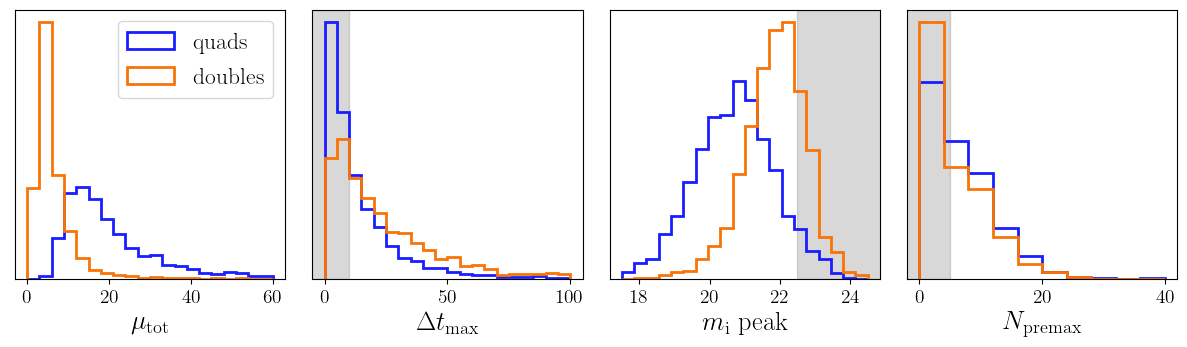

In [20]:

fig, ax = plt.subplots(1, 4, figsize=(15, 3.5))
fig.subplots_adjust(wspace=0.1)

properties_d = [mutot_doubles[md_detected_micro], dt_doubles[md_detected_micro], 
                peak_i_doubles[md_detected_micro], Nearly_d]
properties_q = [mutot_quads[mq_detected_micro], dt_quads[mq_detected_micro], 
                peak_i_quads[mq_detected_micro], Nearly_q]
ranges = [(0, 60), (0, 100), (17.5, 24.5), (0, 40)]
labels = [r'$\mu_{\rm tot}$', r'$\Delta t_{\rm max}$', r'$m_{\rm i}$ peak', r'$N_{\rm premax}$']
bins = [20, 20, 20, 10]
limits = [np.nan, 10, 22.5, 5]
fill = [np.nan, [-50, 10], [22.5, 25], [-5, 5]]
#doubles:00b899 quads:7d42b8

for i in range(4):
    ax[i].hist(properties_q[i], range=ranges[i], histtype='step', lw=2, bins=bins[i], density=True, 
               label='quads',  color='#191dff')
    ax[i].hist(properties_d[i], range=ranges[i], histtype='step', lw=2, bins=bins[i], density=True, 
               label='doubles', color='#f87408')
    ax[i].set_xlabel(labels[i], fontsize=19)
    ax[i].xaxis.set_tick_params(labelsize=14)
    ax[i].set_yticks([])
    ymin, ymax = ax[i].get_ylim()
    xmin, xmax = ax[i].get_xlim()
    
    if not np.isnan(limits[i]):
        #ax[i].axvline(x=limits[i], color='C3', ls='--')
        ax[i].fill_between(fill[i], ymin, ymax, color='gray', alpha=0.3)
        
    ax[i].set_xlim(xmin, xmax)
    ax[i].set_ylim(ymin, ymax)

ax[0].legend(fontsize=17)
# plt.savefig("../Results/Figures/Properties_detected.png", transparent=False, facecolor='white', dpi=250, bbox_inches='tight')
